In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import glob as gb
import cv2
import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import itertools 

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
!pip install split-folders

In [5]:
train_path='/kaggle/working/new/train/'
test_path='/kaggle/working/new/test/'
val_path='/kaggle/working/new/val/'

In [7]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/plantvillage-dataset/color/", output="./new",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 54305 files [01:24, 640.50 files/s] 


In [8]:
traingen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
testgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
validgen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

In [9]:
train_ds=traingen.flow_from_directory(batch_size=64,directory=train_path,shuffle=True,
                                                 target_size=(128, 128),class_mode='categorical')
test_ds=traingen.flow_from_directory(batch_size=64,directory=test_path,shuffle=False,target_size=(128, 128), 
                                                 class_mode='categorical')

val_ds=traingen.flow_from_directory(batch_size=64,directory=val_path,shuffle=True,target_size=(128, 128), 
                                                 class_mode='categorical')

Found 43429 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.


In [10]:
image_size = 128  # We'll resize input images to this size
patch_size = 12  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  
num_classes = 38
input_shape = (128, 128, 3)

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [16]:
model=create_vit_classifier()
model.summary()

2023-01-30 13:33:15.133256: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 432)    0           input_2[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 100, 64)      34112       patches_1[0][0]                  
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 100, 64)      128         patch_encoder[0][0]              
______________________________________________________________________________________________

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),optimizer='adam',
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

In [15]:
history = model.fit(train_ds, steps_per_epoch=len(train_ds),validation_data=val_ds, 
                    validation_steps=len(val_ds),epochs=50,callbacks=[callback],
                    verbose=1 )

2022-12-27 12:33:22.590057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50

679/679 [==============================] - 105s 141ms/step - loss: 2.6544 - accuracy: 0.3072 - val_loss: 1.3717 - val_accuracy: 0.6009

Epoch 2/50

679/679 [==============================] - 94s 138ms/step - loss: 1.3424 - accuracy: 0.6050 - val_loss: 0.7270 - val_accuracy: 0.7825

Epoch 3/50

679/679 [==============================] - 93s 136ms/step - loss: 0.8557 - accuracy: 0.7403 - val_loss: 0.5172 - val_accuracy: 0.8414

Epoch 4/50

679/679 [==============================] - 94s 138ms/step - loss: 0.6113 - accuracy: 0.8110 - val_loss: 0.3941 - val_accuracy: 0.8743

Epoch 5/50

679/679 [==============================] - 92s 136ms/step - loss: 0.4752 - accuracy: 0.8515 - val_loss: 0.2975 - val_accuracy: 0.9023

Epoch 6/50

679/679 [==============================] - 93s 137ms/step - loss: 0.3888 - accuracy: 0.8764 - val_loss: 0.2733 - val_accuracy: 0.9134

Epoch 7/50

679/679 [==============================] - 92s 136ms/step - loss: 0.3302 - accuracy: 0.8956 - val_loss: 0

In [21]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict_generator(test_ds)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 38)

y_test= to_categorical(test_ds.labels, 38)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

2023-01-30 13:34:45.888540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [18]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

In [19]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [20]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [21]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [22]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , model.evaluate_generator(test_ds)) 
print("******************************")
print("Accurayc  : " , Accuracy(test_ds.classes , y_pred1)) 
print("******************************")
print("Precision Score is : " , macro_precision(test_ds.classes , y_pred1))
print("******************************")
print("Recall Scores is : " , macro_recall(test_ds.classes , y_pred1))
print("******************************")
print('F1 Score is : ', macro_F1Score(test_ds.classes , y_pred1))
print("******************************")
print('AUC Score is : ' , AUC(test_ds.classes, y_pred1))

***** Model Evaluations Details ******** 



Test loss, Test acc :  [0.16121821105480194, 0.9595164060592651]

******************************

Accurayc  :  0.959516394944129

******************************

Precision Score is :  0.9337465909514175

******************************

Recall Scores is :  0.9475278113170991

******************************

F1 Score is :  0.9387318889752634

******************************

AUC Score is :  {0: 0.9678833233318037, 1: 0.968068645792886, 2: 0.8748158718468054, 3: 0.9725383796407596, 4: 0.996500346846195, 5: 0.9842611619652532, 6: 0.9878137457312401, 7: 0.9408281287789334, 8: 0.9995317475182619, 9: 0.9240558570782452, 10: 0.9999064020965931, 11: 0.9743890403307958, 12: 0.9889266782063072, 13: 0.985958158278316, 14: 0.9880951358592972, 15: 0.9966712371855645, 16: 0.982014510610532, 17: 0.9999078001106398, 18: 0.9740343855214189, 19: 0.9626164385293039, 20: 0.9795334950550475, 21: 0.9493468930770665, 22: 0.9368569722579461, 23: 0.9988931931377975, 2

In [28]:
def plot_roc_curve(y_test,y_pred):
    n_classes=38
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'
                   ])

    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("VIT Roc Curve")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [24]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [23]:
labels=np.array(["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9","Class 10","Class 11","Class 12","Class 13","Class 14","Class 15","Class 16","Class 17",
                "Class 18","Class 19","Class 20","Class 21","Class 22","Class 23","Class 24","Class 25","Class 26","Class 27","Class 28","Class 29","Class 30","Class 31","Class 32","Class 33","Class 34"
                ,"Class 35","Class 36","Class 37"])

In [24]:
def Confusion_Matrix(y_test , y_pred):
    fig, ax = plt.subplots(figsize=(20,20))

    #cnf_matrix = confusion_matrix()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels,ax=ax,xticks_rotation='vertical'
                                                  ,cmap="Blues")

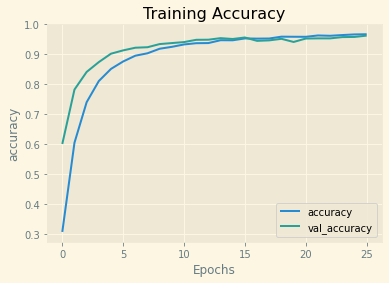

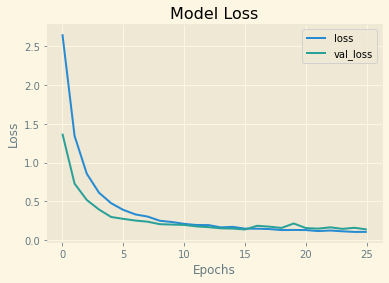

In [27]:
Acc_Loss_Graph(history)

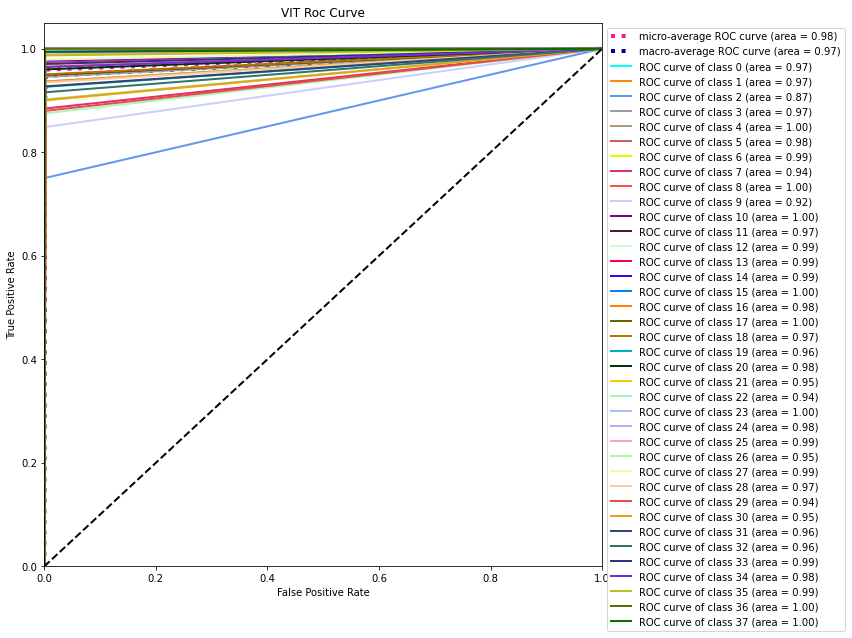

In [29]:
plot_roc_curve(y_test,y_pred2)

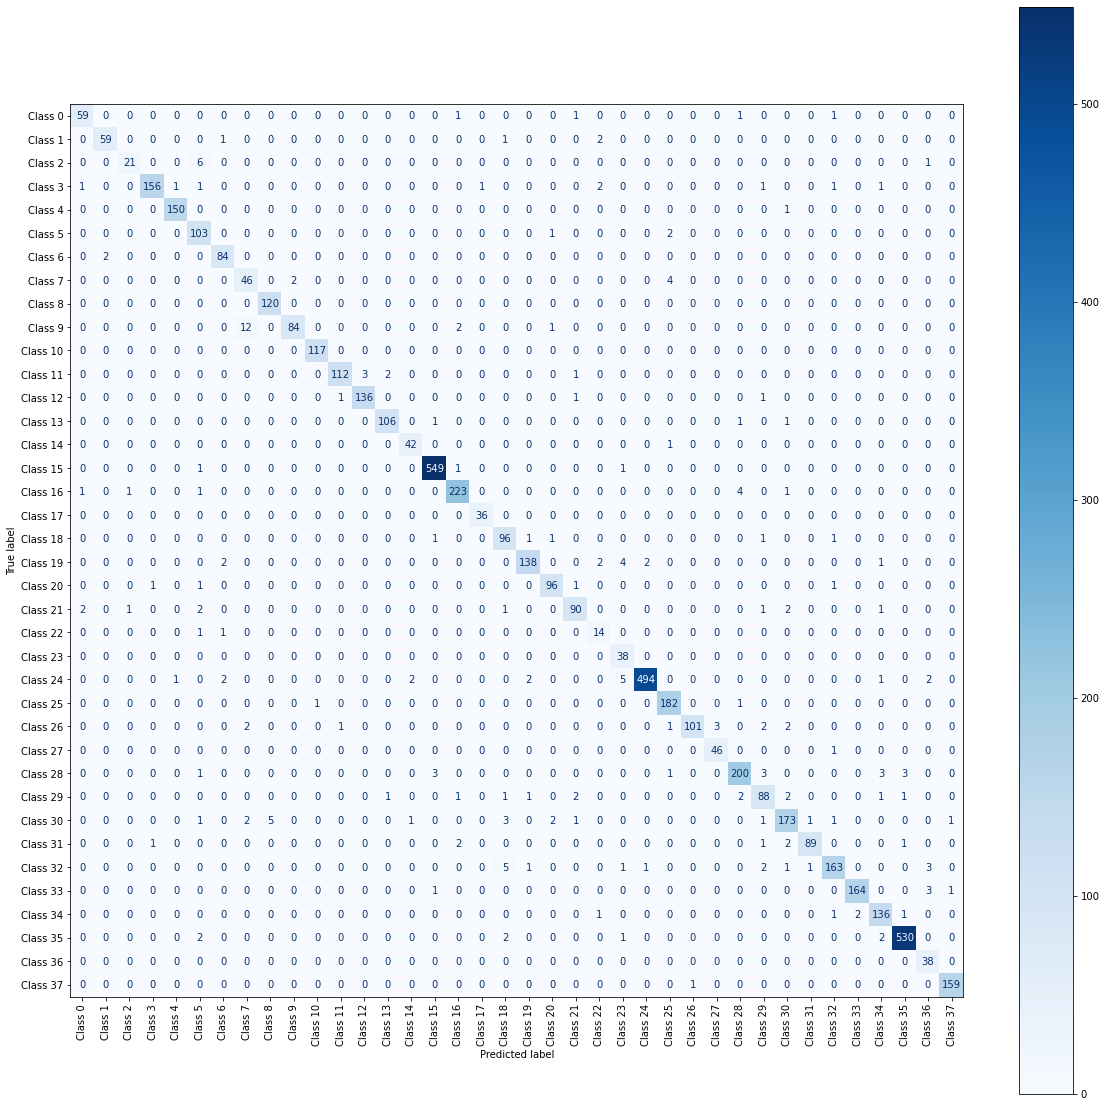

In [26]:
Confusion_Matrix(test_ds.classes , y_pred1)

In [30]:
model.save_weights('/kaggle/working/model1.h5')